In [9]:
import math
import subprocess
import mpmath
from os import path
import numpy as np
import matplotlib.pyplot as plt
import unittest

In [10]:
def correctLog(x):
  return mpmath.log(x)

def testLog(x):
  ret = subprocess.run([path.join((path.abspath('')), path.pardir, "build/tests/logf"),
                        str(x)], capture_output=True, text=True, check=True)
  return float(ret.stdout.strip())

def getUlp(mpf):
  f = np.float32(mpf)
  next = np.nextafter(f, np.float32(np.inf))
  return (next - f).item()

In [11]:
def getDiffBit(f1, f2):
    """Returns the first differing mantissa bit position (0 is least significant)."""
    i1 = np.frombuffer(np.float32(f1).tobytes(), dtype=np.uint32)[0]
    i2 = np.frombuffer(np.float32(f2).tobytes(), dtype=np.uint32)[0]
    diff = i1 ^ i2

    if diff == 0:
      return None

    mantissa_diff = diff & 0x7FFFFF
    if mantissa_diff == 0:
      return None

    return int(mantissa_diff).bit_length() - 1

In [12]:
def plot():
  mid_interval = np.linspace(1.0, 2.0, 1000, dtype=np.float32)
  fig, axs = plt.subplots(2, 2, figsize=(16, 8), constrained_layout=True)
  #fig.suptitle('Test for logf function with 1000 samples in interval [1, 2]')

  test_log = [testLog(x) for x in mid_interval]
  axs[0, 0].set_title('logf test')
  axs[0, 0].plot(mid_interval, test_log)
  axs[0, 0].set_xlabel('x')
  axs[0, 0].set_ylabel('lalogf(x)')

  abs_errors = [abs(mpmath.mpf(y - correctLog(x))) for x, y in zip(mid_interval, test_log)]
  axs[0, 1].set_title('absolute error')
  axs[0, 1].plot(mid_interval, abs_errors)
  axs[0, 1].set_xlabel('x')
  axs[0, 1].set_ylabel('abs error')

  rel_errors = [abs(e / y) if y != 0.0 else 0.0 for e, y in zip(abs_errors, test_log)]
  axs[1, 0].set_title('relative error')
  axs[1, 0].plot(mid_interval, rel_errors)
  axs[1, 0].set_xlabel('x')
  axs[1, 0].set_ylabel('rel error')

  diffBits = [getDiffBit(y, correctLog(x)) for x, y in zip(mid_interval, test_log)]
  bit_counts = [0] * 23
  for bit in diffBits:
    if bit is not None:
      bit_counts[bit] += 1

  axs[1, 1].set_title('mantissa error bit distribution')
  axs[1, 1].bar(range(23), bit_counts)
  axs[1, 1].set_xlabel('mantissa bit position')
  axs[1, 1].set_ylabel('count')

  for ax in np.ravel(axs):
    ax.grid(which='major')
    ax.grid(which='minor', linestyle='--')
    ax.minorticks_on()

  plt.savefig('graphs/lalogf.png')

In [13]:
MAX_ULP_ERROR = 3.5

class TestLogf(unittest.TestCase):
  def test_ulp_precision(self):
    segments = [
        np.linspace(2.0**e, 2.0**(e + 1), 1000, dtype=np.float32)
        for e in range(-127, 127)
    ]
    test_set = np.concatenate(segments)
    ulp_errors = []
    for x in test_set:
      expected = correctLog(x)
      res = testLog(x)
      ulp = getUlp(res)
      error = abs(mpmath.mpf(res) - expected)
      ulp_error = float(abs(error / mpmath.mpf(ulp))) if ulp != 0.0 else 0.0
      print(f'x = {x}, ulp_error = {ulp_error}')
      self.assertTrue(ulp_error <= MAX_ULP_ERROR)
      ulp_errors.append(ulp_error)

    max_ulp_error = max(ulp_errors)
    print(f'max ulp error: {max_ulp_error}')

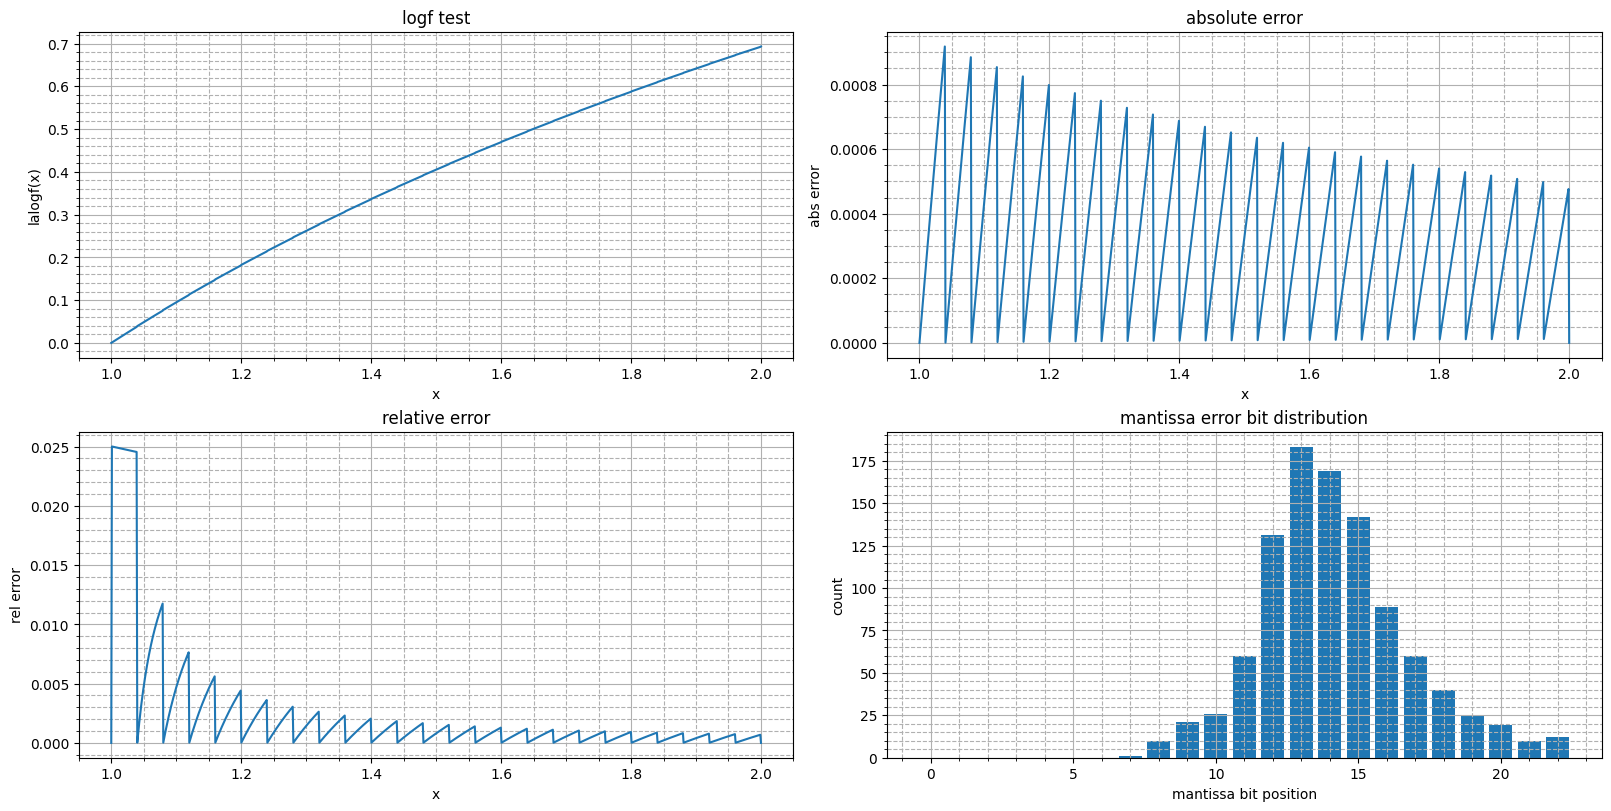

In [14]:
plot()

In [15]:

if __name__ == "__main__":
  unittest.main(argv=[''])

F
FAIL: test_ulp_precision (__main__.TestLogf.test_ulp_precision)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/rv/yhrtt14j28951pqmbr82j5cc0000gn/T/ipykernel_31912/3173673975.py", line 18, in test_ulp_precision
    self.assertTrue(ulp_error <= MAX_ULP_ERROR)
    ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: False is not true

----------------------------------------------------------------------
Ran 1 test in 0.007s

FAILED (failures=1)


x = 5.877471754111438e-39, ulp_error = 53144.78078860231


SystemExit: 1

/Users/victorbaldin/Projects/lalogf/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
